In [1]:
import os
import sys
import random
import datetime
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, vstack
import matplotlib.pyplot as plt
import tqdm
import anndata as ad
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import torch
import torch.nn.functional as F
import torch.distributed as dist
from torch_geometric.nn.inits import glorot, zeros
from pathlib import Path
from models import scFP_Trainer
from misc.utils import set_seed, set_filename, setup_logger
from argument import parse_args
import scgpt as scg
import importlib
from scipy.sparse import csr_matrix, vstack
from sklearn.preprocessing import LabelEncoder
from anndata import concat as ad_concat
from conditional_autoencoder import ConditionalAutoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/work/magroup/ehaber/newconda/envs/scgpt5/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:


def concatenate_anndata(adata_list):
    concatenated_adata = ad_concat(adata_list, axis=0)
    return concatenated_adata


class Data:
    def __init__(self, x, batch, uce, cell):
        self.x = x
        self.batch = batch
        self.cell = cell

    def to(self, device):
        self.x = self.x.to(device)
        self.batch = self.batch.to(device)
        self.cell = self.cell.to(device)
        return self


def prepare_data_for_training(concat_adata, subset_indices):
    # Convert AnnData object to PyTorch Tensor
    node_features = concat_adata.obsm['X_scGPT'][subset_indices]
    if isinstance(node_features, np.ndarray):
        node_features = torch.FloatTensor(node_features)
    else:  # Assuming it's a sparse matrix
        node_features = torch.FloatTensor(node_features.todense())

    scgpt_info = torch.from_numpy(concat_adata.obsm['X_scGPT'][subset_indices])
    batch_info = torch.tensor(concat_adata.obs['batch'][subset_indices].values)
    
    label_encoder = LabelEncoder()
    cell_info_encoded = label_encoder.fit_transform(concat_adata.obs['class'][subset_indices].values)
    cell_info = torch.tensor(cell_info_encoded)

    return Data(
        x=node_features,
        batch=batch_info,
        cell=cell_info
    )


def evaluate_final(data, model, device):
    with torch.no_grad():
        x = data.x.to(device)
        batch = data.batch.to(device)
        
        embeddings = model.encode(x, batch).cpu().numpy()  # Get the latent embeddings and move to CPU
        
    adata = ad.AnnData(X=embeddings)
    adata.obs['batch'] = data.batch.cpu().numpy()
    adata.obs['class'] = data.cell.cpu().numpy()

    # Convert batch and class columns to categorical
    adata.obs['batch'] = adata.obs['batch'].astype('category')
    adata.obs['class'] = adata.obs['class'].astype('category')

    sc.pp.neighbors(adata, use_rep='X')  
    sc.tl.leiden(adata, resolution=1.0)
    sc.tl.umap(adata)  
    
    sc.pl.umap(adata, color=['class'])
    sc.pl.umap(adata, color=['batch'])  


In [20]:
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Function to find mutual nearest neighbors between two batches
def find_mutual_nearest_neighbors(embeddings_batch_A, embeddings_batch_B, n_neighbors=50):
    # Find neighbors in both directions
    knn_A_to_B = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(embeddings_batch_B)
    distances_A_to_B, indices_A_to_B = knn_A_to_B.kneighbors(embeddings_batch_A)

    knn_B_to_A = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(embeddings_batch_A)
    distances_B_to_A, indices_B_to_A = knn_B_to_A.kneighbors(embeddings_batch_B)

    # Find mutual nearest neighbors within top-k neighbors
    mutual_pairs = []
    for i, neighbors_in_B in enumerate(indices_A_to_B):
        for neighbor_in_B in neighbors_in_B:
            if i in indices_B_to_A[neighbor_in_B]:
                mutual_pairs.append((i, neighbor_in_B)) 
                break  

    print(f"Number of mutual pairs found: {len(mutual_pairs)}")
    return mutual_pairs

# Function to calculate triplet loss
def triplet_loss(latent_A, latent_B, mutual_pairs, negative_indices_A, margin=1.0):
    if not mutual_pairs:
        return torch.tensor(0.0, device=latent_A.device, requires_grad=True)
    
    # Extract indices for anchors, positives, and negatives
    indices_A = torch.tensor([i for i, _ in mutual_pairs], dtype=torch.long, device=latent_A.device)
    indices_B = torch.tensor([j for _, j in mutual_pairs], dtype=torch.long, device=latent_B.device)
    negative_indices = negative_indices_A.to(device=latent_A.device)
    
    # Gather embeddings
    anchors = latent_A[indices_A]
    positives = latent_B[indices_B]
    negatives = latent_A[negative_indices]
    
    # Compute triplet loss using vectorization
    triplet_loss_fn = torch.nn.TripletMarginLoss(margin=margin, reduction='mean')
    loss = triplet_loss_fn(anchors, positives, negatives)
    return loss

# Function to compute neighborhood preservation loss
def neighborhood_preservation_loss(latent_embeddings, neighbor_indices, original_distances):
    # latent embeddings of neighbors
    anchors = latent_embeddings.unsqueeze(1)  
    neighbors = latent_embeddings[neighbor_indices]  

    # Compute distances in latent space
    latent_distances = torch.norm(anchors - neighbors, dim=2)  

    # squared differences between latent and original distances
    distance_diffs = (latent_distances - original_distances) ** 2 

    loss = distance_diffs.mean()
    return loss



In [28]:
def train_autoencoder_mnn_triplet(
    model,
    args,
    data,
    lr,
    epochs,
    evaluate_interval=10,
    lamb=0.5,  
    lamb_neighborhood=15.0, 
    pretrain_epochs=50,
    margin=1.0,
    knn=100,
    update_interval=15
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    
    data.x = data.x.to(device)
    data.batch = data.batch.to(device)
    data.cell = data.cell.to(device)
    
    original_embeddings = data.x.detach().cpu().numpy()

    # Number of neighbors for neighborhood preservation
    k_neighbors = 30 

    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='auto', metric='euclidean').fit(original_embeddings)
    distances, indices = nbrs.kneighbors(original_embeddings)

    # Exclude self 
    neighbor_indices = indices[:, 1:]
    neighbor_distances = distances[:, 1:]  

    neighbor_indices_tensor = torch.tensor(neighbor_indices, dtype=torch.long, device=device)
    original_distances_tensor = torch.tensor(neighbor_distances, dtype=torch.float32, device=device)
    
    # Track the loss 
    train_losses = []
    autoencoder_losses = []
    triplet_losses = []
    neighborhood_losses = []
    
    mutual_pairs = None  # Initialize mutual_pairs to None
    
    # Total epochs after pretraining
    total_epochs_post_pretrain = epochs - pretrain_epochs

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
    
        # Get latent embeddings
        latent_embeddings = model.encode(data.x, data.batch)
    
        # Reconstruct from latent embeddings
        recon_x = model.decode(latent_embeddings, data.batch)
        autoencoder_loss = model.loss(recon_x, data.x)
        
        # Compute neighborhood preservation loss
        neighborhood_loss = neighborhood_preservation_loss(latent_embeddings, neighbor_indices_tensor, original_distances_tensor)
        
        if epoch < pretrain_epochs:
            # Only use autoencoder and neighborhood loss during pre-training
            loss = autoencoder_loss + lamb_neighborhood * neighborhood_loss
            triplet_loss_value = torch.tensor(0.0, device=device, requires_grad=True)
            lamb_current = 0.0  # No triplet loss during pre-training
        else:
            # Gradually increase lamb over epochs
            lamb_current = lamb * ((epoch - pretrain_epochs + 1) / total_epochs_post_pretrain)
            # Ensure lamb_current does not exceed lamb
            lamb_current = min(lamb_current, lamb)
            
            latent_A = latent_embeddings[data.batch.squeeze() == 0]
            latent_B = latent_embeddings[data.batch.squeeze() == 1]
    
            # Recompute mutual_pairs
            if (epoch - pretrain_epochs) % update_interval == 0 or mutual_pairs is None:
                print(f"Recomputing triplets at epoch {epoch}")
    
                # Find mutual nearest neighbors between batch A and batch B
                mutual_pairs = find_mutual_nearest_neighbors(
                    latent_A.detach().cpu().numpy(), latent_B.detach().cpu().numpy(), n_neighbors=knn
                )
    
            # Check if mutual pairs are available
            if not mutual_pairs:
                print("No mutual pairs found.")
                triplet_loss_value = torch.tensor(0.0, device=device, requires_grad=True)
            else:
                negative_indices_A = torch.randint(0, latent_A.shape[0], (len(mutual_pairs),), device=latent_A.device)
    
                # Calculate triplet loss
                triplet_loss_value = triplet_loss(latent_A, latent_B, mutual_pairs, negative_indices_A, margin=margin)
    
            loss = autoencoder_loss + lamb_current * triplet_loss_value + lamb_neighborhood * neighborhood_loss
    
        # Record the losses
        train_losses.append(loss.item())
        autoencoder_losses.append(autoencoder_loss.item())
        triplet_losses.append(triplet_loss_value.item())
        neighborhood_losses.append(neighborhood_loss.item())
    
        loss.backward()
        optimizer.step()
    
        # Print loss at intervals
        if epoch % evaluate_interval == 0:
            if epoch >= pretrain_epochs:
                print(f'Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}, AE Loss: {autoencoder_loss.item():.4f}, '
                      f'Triplet Loss: {triplet_loss_value.item():.4f}, Neighborhood Loss: {neighborhood_loss.item():.4f}, '
                      f'Lambda Triplet: {lamb_current:.4f}')
            else:
                print(f'Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}, AE Loss: {autoencoder_loss.item():.4f}, '
                      f'Neighborhood Loss: {neighborhood_loss.item():.4f}')
    
    # Plot the loss curves after training
    epochs_range = range(1, epochs + 1)

    # Plot Total Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_losses, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss Curve')
    plt.legend()
    plt.show()

    # Plot Autoencoder Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, autoencoder_losses, label='Autoencoder Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder Loss Curve')
    plt.legend()
    plt.show()

    # Plot Triplet Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, triplet_losses, label='Triplet Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Triplet Loss Curve')
    plt.legend()
    plt.show()

    # Plot Neighborhood Preservation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, neighborhood_losses, label='Neighborhood Loss', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neighborhood Preservation Loss Curve')
    plt.legend()
    plt.show()
    
    return model

/work/magroup/ehaber/newconda/envs/scgpt5/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_40558/2699946286.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.batch = torch.tensor(data.batch, dtype=torch.float32).unsqueeze(1).to(device)


Epoch 1/200, Total Loss: 4.4634, AE Loss: 0.0034, Neighborhood Loss: 0.0446
Epoch 11/200, Total Loss: 3.1272, AE Loss: 0.0028, Neighborhood Loss: 0.0312
Epoch 21/200, Total Loss: 2.0775, AE Loss: 0.0025, Neighborhood Loss: 0.0208
Epoch 31/200, Total Loss: 1.3846, AE Loss: 0.0022, Neighborhood Loss: 0.0138
Epoch 41/200, Total Loss: 1.0279, AE Loss: 0.0020, Neighborhood Loss: 0.0103
Recomputing triplets at epoch 50
Number of mutual pairs found: 31296
Epoch 51/200, Total Loss: 0.8314, AE Loss: 0.0018, Triplet Loss: 1.0395, Neighborhood Loss: 0.0083, Lambda Triplet: 0.0027
Epoch 61/200, Total Loss: 0.7155, AE Loss: 0.0017, Triplet Loss: 1.0119, Neighborhood Loss: 0.0068, Lambda Triplet: 0.0293
Epoch 71/200, Total Loss: 0.6446, AE Loss: 0.0016, Triplet Loss: 0.9866, Neighborhood Loss: 0.0059, Lambda Triplet: 0.0560
Recomputing triplets at epoch 75
Number of mutual pairs found: 42408
Epoch 81/200, Total Loss: 0.5982, AE Loss: 0.0015, Triplet Loss: 0.9666, Neighborhood Loss: 0.0052, Lambda Tr

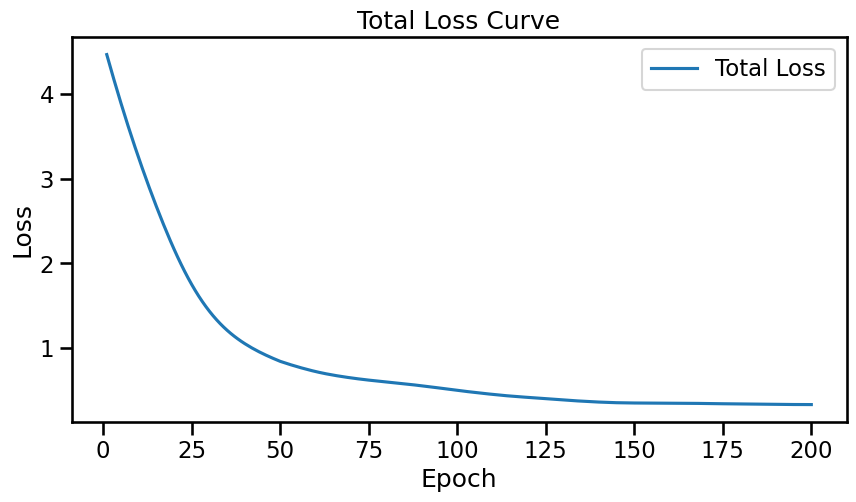

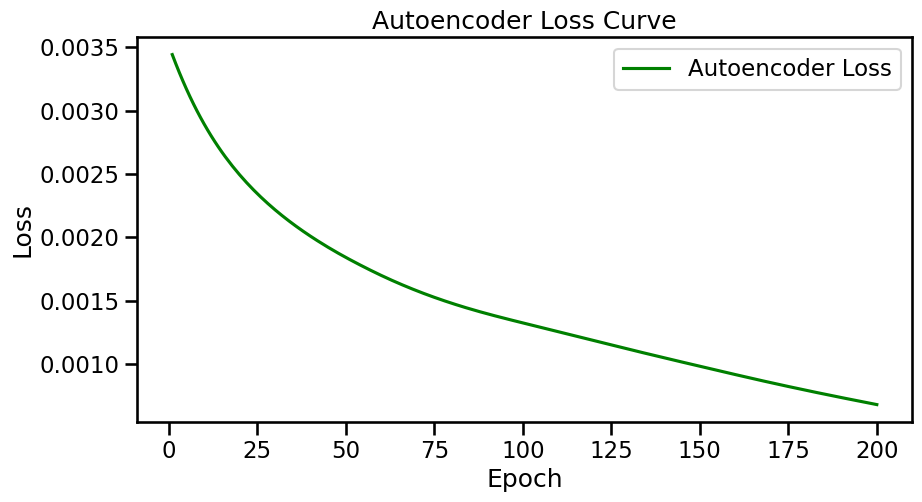

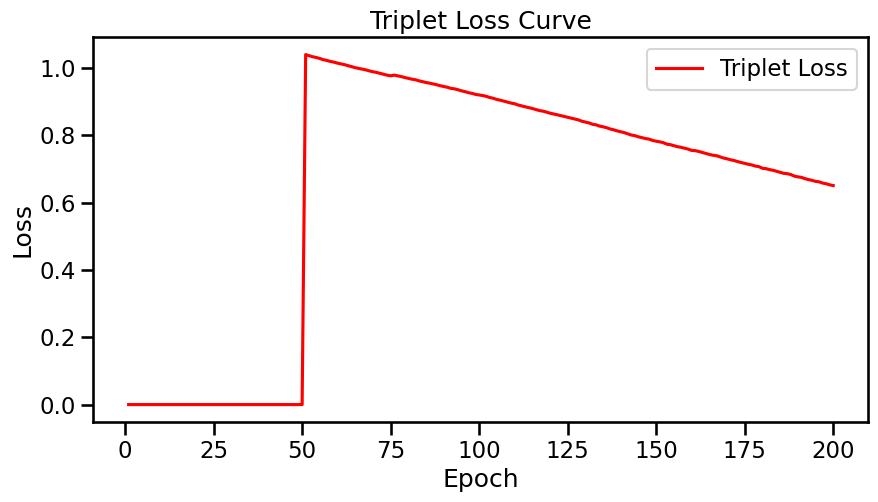

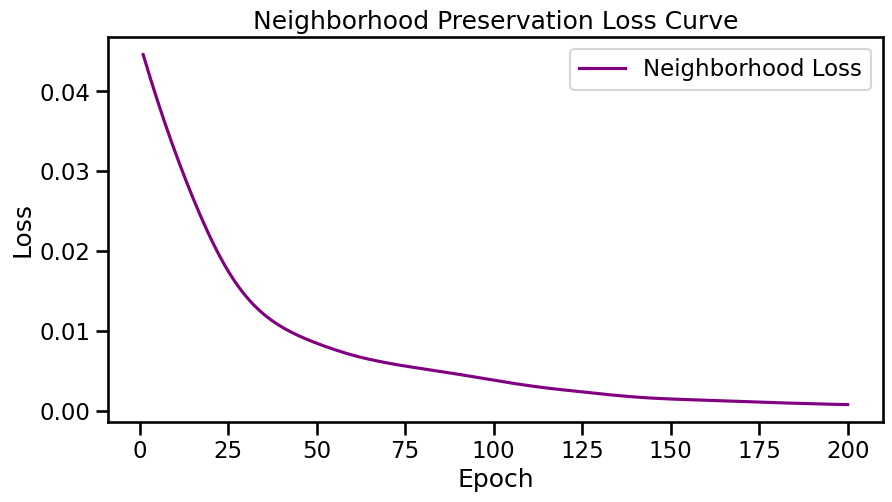

/work/magroup/ehaber/newconda/envs/scgpt5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


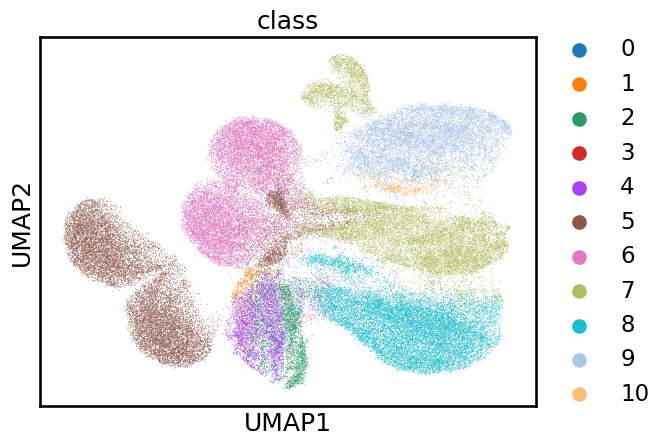

/work/magroup/ehaber/newconda/envs/scgpt5/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


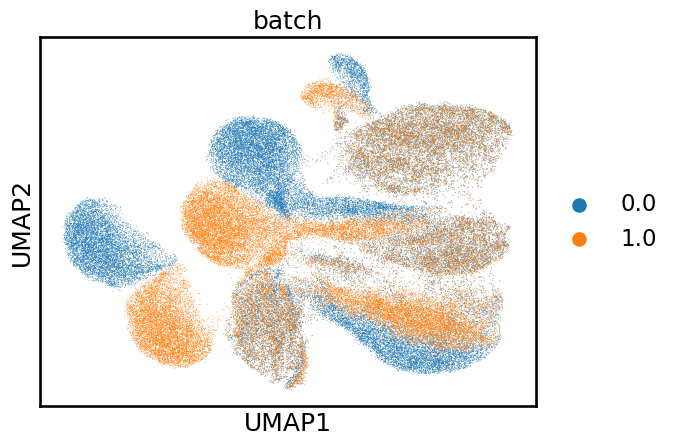

Processed batch 1, current GPU memory usage: 8.38 GB


In [30]:
import os
import torch
import anndata

torch.cuda.empty_cache()


zhuang_dir = '/work/magroup/ehaber/LLOKI/scgpt/merfish500'
sec37_dir = '/work/magroup/ehaber/LLOKI/scgpt/merfish1100'

# List files in directories
zhuang_files = sorted([os.path.join(zhuang_dir, f) for f in os.listdir(zhuang_dir) if f.endswith('.h5ad')])
sec37_files = sorted([os.path.join(sec37_dir, f) for f in os.listdir(sec37_dir) if f.endswith('.h5ad')])


#development for two slice example
zhuang_files = zhuang_files[2:3]
sec37_files = sec37_files[2:3]


batch_size = 2  

torch.cuda.empty_cache()
initial_memory = torch.cuda.memory_allocated()

device = torch.device("cuda")

args = {
    'enc_in_channels': 512,  
    'latent_dim': 512  
}
batch_dim = 1
model = ConditionalAutoencoder(enc_in_channels=args['enc_in_channels'], batch_dim=batch_dim, latent_dim=args['latent_dim']).to(device)





for i in range(0, len(zhuang_files), batch_size):
    z_batch_files = zhuang_files[i:i + batch_size]
    s_batch_files = zhuang_files[i:i + batch_size]

    z_batch = []
    s_batch = []
    
    for z_file, s_file in zip(z_batch_files, s_batch_files):
        z_sub = anndata.read_h5ad(z_file)
        s_sub = anndata.read_h5ad(s_file)
        
        z_sub.obs['batch'] = 0
        s_sub.obs['batch'] = 1

        z_batch.append(z_sub)
        s_batch.append(s_sub)

    combined_batch = z_batch + s_batch
    concatenated_subgraph = concatenate_anndata(combined_batch)
    
    subset_indices = np.arange(concatenated_subgraph.shape[0])
    data = prepare_data_for_training(concatenated_subgraph, subset_indices)
    data.batch = torch.tensor(data.batch, dtype=torch.float32).unsqueeze(1).to(device)
    data = data.to(device)  # Move the data to the appropriate device
    
    model = train_autoencoder_mnn_triplet(model, args, data, lr=0.0001, knn=10, epochs=200, pretrain_epochs=50, update_interval=25, lamb=0.4, lamb_neighborhood=100)
    
    evaluate_final(data, model, device)
    
    current_memory = torch.cuda.memory_allocated()
    if current_memory - initial_memory > 1e9:  # If more than 1GB of extra memory is used
        print("Clearing CUDA cache due to high memory usage")
        torch.cuda.empty_cache()
        current_memory = torch.cuda.memory_allocated()
    
    print(f"Processed batch {i // batch_size + 1}, current GPU memory usage: {current_memory / 1e9:.2f} GB")

